# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:58 - loss: 0.6937

  30/1875 [..............................] - ETA: 3s - loss: 0.5422   

  58/1875 [..............................] - ETA: 3s - loss: 0.4663

  86/1875 [>.............................] - ETA: 3s - loss: 0.4253

 116/1875 [>.............................] - ETA: 3s - loss: 0.3971

 147/1875 [=>............................] - ETA: 2s - loss: 0.3763

 177/1875 [=>............................] - ETA: 2s - loss: 0.3608

 201/1875 [==>...........................] - ETA: 2s - loss: 0.3506

 233/1875 [==>...........................] - ETA: 2s - loss: 0.3390

 261/1875 [===>..........................] - ETA: 2s - loss: 0.3302

 289/1875 [===>..........................] - ETA: 2s - loss: 0.3225

 326/1875 [====>.........................] - ETA: 2s - loss: 0.3135

 363/1875 [====>.........................] - ETA: 2s - loss: 0.3057

 402/1875 [=====>........................] - ETA: 2s - loss: 0.2983

 439/1875 [======>.......................] - ETA: 2s - loss: 0.2921

 469/1875 [======>.......................] - ETA: 2s - loss: 0.2875

 505/1875 [=======>......................] - ETA: 2s - loss: 0.2824

 543/1875 [=======>......................] - ETA: 2s - loss: 0.2775

 580/1875 [========>.....................] - ETA: 2s - loss: 0.2730

 619/1875 [========>.....................] - ETA: 1s - loss: 0.2687

 653/1875 [=========>....................] - ETA: 1s - loss: 0.2652

 686/1875 [=========>....................] - ETA: 1s - loss: 0.2620

 720/1875 [==========>...................] - ETA: 1s - loss: 0.2588

 756/1875 [===========>..................] - ETA: 1s - loss: 0.2557

 783/1875 [===========>..................] - ETA: 1s - loss: 0.2535

 821/1875 [============>.................] - ETA: 1s - loss: 0.2505

 860/1875 [============>.................] - ETA: 1s - loss: 0.2476

 893/1875 [=============>................] - ETA: 1s - loss: 0.2452

 914/1875 [=============>................] - ETA: 1s - loss: 0.2438

 945/1875 [==============>...............] - ETA: 1s - loss: 0.2418

 972/1875 [==============>...............] - ETA: 1s - loss: 0.2400

1002/1875 [===============>..............] - ETA: 1s - loss: 0.2382

1038/1875 [===============>..............] - ETA: 1s - loss: 0.2361

1071/1875 [================>.............] - ETA: 1s - loss: 0.2342

1105/1875 [================>.............] - ETA: 1s - loss: 0.2323

1141/1875 [=================>............] - ETA: 1s - loss: 0.2305

1175/1875 [=================>............] - ETA: 1s - loss: 0.2287

1212/1875 [==================>...........] - ETA: 1s - loss: 0.2269

1250/1875 [===================>..........] - ETA: 0s - loss: 0.2251

1283/1875 [===================>..........] - ETA: 0s - loss: 0.2236

1314/1875 [====================>.........] - ETA: 0s - loss: 0.2223

1349/1875 [====================>.........] - ETA: 0s - loss: 0.2208

1387/1875 [=====================>........] - ETA: 0s - loss: 0.2192

1425/1875 [=====================>........] - ETA: 0s - loss: 0.2177

1455/1875 [======================>.......] - ETA: 0s - loss: 0.2165

1489/1875 [======================>.......] - ETA: 0s - loss: 0.2152

1523/1875 [=======================>......] - ETA: 0s - loss: 0.2140

1548/1875 [=======================>......] - ETA: 0s - loss: 0.2131

1584/1875 [========================>.....] - ETA: 0s - loss: 0.2118

1619/1875 [========================>.....] - ETA: 0s - loss: 0.2106

1659/1875 [=========================>....] - ETA: 0s - loss: 0.2093

1700/1875 [==========================>...] - ETA: 0s - loss: 0.2080

1742/1875 [==========================>...] - ETA: 0s - loss: 0.2066

1783/1875 [===========================>..] - ETA: 0s - loss: 0.2054

1826/1875 [============================>.] - ETA: 0s - loss: 0.2041

1869/1875 [============================>.] - ETA: 0s - loss: 0.2029

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2027


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1244

  42/1875 [..............................] - ETA: 2s - loss: 0.1111

  80/1875 [>.............................] - ETA: 2s - loss: 0.1108

 118/1875 [>.............................] - ETA: 2s - loss: 0.1105

 159/1875 [=>............................] - ETA: 2s - loss: 0.1103

 199/1875 [==>...........................] - ETA: 2s - loss: 0.1101

 231/1875 [==>...........................] - ETA: 2s - loss: 0.1100

 263/1875 [===>..........................] - ETA: 2s - loss: 0.1099

 299/1875 [===>..........................] - ETA: 2s - loss: 0.1098

 337/1875 [====>.........................] - ETA: 2s - loss: 0.1096

 376/1875 [=====>........................] - ETA: 2s - loss: 0.1095

 417/1875 [=====>........................] - ETA: 1s - loss: 0.1094

 457/1875 [======>.......................] - ETA: 1s - loss: 0.1093

 497/1875 [======>.......................] - ETA: 1s - loss: 0.1092

 538/1875 [=======>......................] - ETA: 1s - loss: 0.1091

 581/1875 [========>.....................] - ETA: 1s - loss: 0.1090

 624/1875 [========>.....................] - ETA: 1s - loss: 0.1089

 667/1875 [=========>....................] - ETA: 1s - loss: 0.1088

 710/1875 [==========>...................] - ETA: 1s - loss: 0.1087

 751/1875 [===========>..................] - ETA: 1s - loss: 0.1086

 791/1875 [===========>..................] - ETA: 1s - loss: 0.1085

 832/1875 [============>.................] - ETA: 1s - loss: 0.1084

 871/1875 [============>.................] - ETA: 1s - loss: 0.1083

 910/1875 [=============>................] - ETA: 1s - loss: 0.1082

 949/1875 [==============>...............] - ETA: 1s - loss: 0.1081

 988/1875 [==============>...............] - ETA: 1s - loss: 0.1080

1026/1875 [===============>..............] - ETA: 1s - loss: 0.1079

1064/1875 [================>.............] - ETA: 1s - loss: 0.1078

1102/1875 [================>.............] - ETA: 0s - loss: 0.1078

1140/1875 [=================>............] - ETA: 0s - loss: 0.1077

1177/1875 [=================>............] - ETA: 0s - loss: 0.1076

1215/1875 [==================>...........] - ETA: 0s - loss: 0.1075

1253/1875 [===================>..........] - ETA: 0s - loss: 0.1074

1292/1875 [===================>..........] - ETA: 0s - loss: 0.1074

1333/1875 [====================>.........] - ETA: 0s - loss: 0.1073

1376/1875 [=====================>........] - ETA: 0s - loss: 0.1072

1416/1875 [=====================>........] - ETA: 0s - loss: 0.1071

1457/1875 [======================>.......] - ETA: 0s - loss: 0.1070

1499/1875 [======================>.......] - ETA: 0s - loss: 0.1070

1540/1875 [=======================>......] - ETA: 0s - loss: 0.1069

1581/1875 [========================>.....] - ETA: 0s - loss: 0.1068

1619/1875 [========================>.....] - ETA: 0s - loss: 0.1067

1657/1875 [=========================>....] - ETA: 0s - loss: 0.1067

1696/1875 [==========================>...] - ETA: 0s - loss: 0.1066

1736/1875 [==========================>...] - ETA: 0s - loss: 0.1065

1776/1875 [===========================>..] - ETA: 0s - loss: 0.1065

1815/1875 [============================>.] - ETA: 0s - loss: 0.1064

1855/1875 [============================>.] - ETA: 0s - loss: 0.1063

1875/1875 [==============================] - 2s 1ms/step - loss: 0.1063


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1045

  39/1875 [..............................] - ETA: 2s - loss: 0.0990

  74/1875 [>.............................] - ETA: 2s - loss: 0.0987

 110/1875 [>.............................] - ETA: 2s - loss: 0.0988

 148/1875 [=>............................] - ETA: 2s - loss: 0.0989

 187/1875 [=>............................] - ETA: 2s - loss: 0.0989

 226/1875 [==>...........................] - ETA: 2s - loss: 0.0989

 266/1875 [===>..........................] - ETA: 2s - loss: 0.0989

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0989

 335/1875 [====>.........................] - ETA: 2s - loss: 0.0988

 368/1875 [====>.........................] - ETA: 2s - loss: 0.0988

 405/1875 [=====>........................] - ETA: 2s - loss: 0.0988

 444/1875 [======>.......................] - ETA: 1s - loss: 0.0988

 483/1875 [======>.......................] - ETA: 1s - loss: 0.0988

 522/1875 [=======>......................] - ETA: 1s - loss: 0.0988

 560/1875 [=======>......................] - ETA: 1s - loss: 0.0987

 596/1875 [========>.....................] - ETA: 1s - loss: 0.0987

 639/1875 [=========>....................] - ETA: 1s - loss: 0.0987

 680/1875 [=========>....................] - ETA: 1s - loss: 0.0987

 719/1875 [==========>...................] - ETA: 1s - loss: 0.0986

 758/1875 [===========>..................] - ETA: 1s - loss: 0.0986

 798/1875 [===========>..................] - ETA: 1s - loss: 0.0986

 838/1875 [============>.................] - ETA: 1s - loss: 0.0986

 877/1875 [=============>................] - ETA: 1s - loss: 0.0986

 917/1875 [=============>................] - ETA: 1s - loss: 0.0985

 952/1875 [==============>...............] - ETA: 1s - loss: 0.0985

 992/1875 [==============>...............] - ETA: 1s - loss: 0.0985

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0985

1075/1875 [================>.............] - ETA: 1s - loss: 0.0985

1116/1875 [================>.............] - ETA: 1s - loss: 0.0984

1157/1875 [=================>............] - ETA: 0s - loss: 0.0984

1198/1875 [==================>...........] - ETA: 0s - loss: 0.0984

1237/1875 [==================>...........] - ETA: 0s - loss: 0.0984

1275/1875 [===================>..........] - ETA: 0s - loss: 0.0984

1314/1875 [====================>.........] - ETA: 0s - loss: 0.0984

1350/1875 [====================>.........] - ETA: 0s - loss: 0.0984

1390/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1507/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1542/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1576/1875 [========================>.....] - ETA: 0s - loss: 0.0983

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0983

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1835/1875 [============================>.] - ETA: 0s - loss: 0.0982

1873/1875 [============================>.] - ETA: 0s - loss: 0.0982

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0982


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0952

  40/1875 [..............................] - ETA: 2s - loss: 0.0968

  75/1875 [>.............................] - ETA: 2s - loss: 0.0971

 113/1875 [>.............................] - ETA: 2s - loss: 0.0971

 152/1875 [=>............................] - ETA: 2s - loss: 0.0970

 191/1875 [==>...........................] - ETA: 2s - loss: 0.0970

 228/1875 [==>...........................] - ETA: 2s - loss: 0.0970

 266/1875 [===>..........................] - ETA: 2s - loss: 0.0970

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0970

 342/1875 [====>.........................] - ETA: 2s - loss: 0.0970

 380/1875 [=====>........................] - ETA: 1s - loss: 0.0969

 417/1875 [=====>........................] - ETA: 1s - loss: 0.0969

 455/1875 [======>.......................] - ETA: 1s - loss: 0.0969

 494/1875 [======>.......................] - ETA: 1s - loss: 0.0968

 532/1875 [=======>......................] - ETA: 1s - loss: 0.0968

 571/1875 [========>.....................] - ETA: 1s - loss: 0.0968

 607/1875 [========>.....................] - ETA: 1s - loss: 0.0968

 646/1875 [=========>....................] - ETA: 1s - loss: 0.0967

 686/1875 [=========>....................] - ETA: 1s - loss: 0.0967

 726/1875 [==========>...................] - ETA: 1s - loss: 0.0967

 766/1875 [===========>..................] - ETA: 1s - loss: 0.0967

 807/1875 [===========>..................] - ETA: 1s - loss: 0.0967

 848/1875 [============>.................] - ETA: 1s - loss: 0.0966

 889/1875 [=============>................] - ETA: 1s - loss: 0.0966

 928/1875 [=============>................] - ETA: 1s - loss: 0.0966

 969/1875 [==============>...............] - ETA: 1s - loss: 0.0966

1009/1875 [===============>..............] - ETA: 1s - loss: 0.0966

1048/1875 [===============>..............] - ETA: 1s - loss: 0.0966

1088/1875 [================>.............] - ETA: 1s - loss: 0.0965

1129/1875 [=================>............] - ETA: 0s - loss: 0.0965

1169/1875 [=================>............] - ETA: 0s - loss: 0.0965

1209/1875 [==================>...........] - ETA: 0s - loss: 0.0965

1248/1875 [==================>...........] - ETA: 0s - loss: 0.0965

1283/1875 [===================>..........] - ETA: 0s - loss: 0.0965

1321/1875 [====================>.........] - ETA: 0s - loss: 0.0965

1361/1875 [====================>.........] - ETA: 0s - loss: 0.0965

1398/1875 [=====================>........] - ETA: 0s - loss: 0.0965

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0965

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0965

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0965

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0965

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0965

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1769/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1851/1875 [============================>.] - ETA: 0s - loss: 0.0964

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0964


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1008

  42/1875 [..............................] - ETA: 2s - loss: 0.0961

  82/1875 [>.............................] - ETA: 2s - loss: 0.0960

 121/1875 [>.............................] - ETA: 2s - loss: 0.0957

 159/1875 [=>............................] - ETA: 2s - loss: 0.0956

 198/1875 [==>...........................] - ETA: 2s - loss: 0.0955

 236/1875 [==>...........................] - ETA: 2s - loss: 0.0955

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 311/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 349/1875 [====>.........................] - ETA: 1s - loss: 0.0954

 389/1875 [=====>........................] - ETA: 1s - loss: 0.0953

 426/1875 [=====>........................] - ETA: 1s - loss: 0.0953

 467/1875 [======>.......................] - ETA: 1s - loss: 0.0953

 507/1875 [=======>......................] - ETA: 1s - loss: 0.0953

 545/1875 [=======>......................] - ETA: 1s - loss: 0.0953

 586/1875 [========>.....................] - ETA: 1s - loss: 0.0953

 627/1875 [=========>....................] - ETA: 1s - loss: 0.0953

 667/1875 [=========>....................] - ETA: 1s - loss: 0.0953

 703/1875 [==========>...................] - ETA: 1s - loss: 0.0953

 742/1875 [==========>...................] - ETA: 1s - loss: 0.0953

 785/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 828/1875 [============>.................] - ETA: 1s - loss: 0.0953

 869/1875 [============>.................] - ETA: 1s - loss: 0.0953

 909/1875 [=============>................] - ETA: 1s - loss: 0.0953

 951/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0953

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1077/1875 [================>.............] - ETA: 1s - loss: 0.0953

1112/1875 [================>.............] - ETA: 0s - loss: 0.0953

1144/1875 [=================>............] - ETA: 0s - loss: 0.0953

1184/1875 [=================>............] - ETA: 0s - loss: 0.0953

1224/1875 [==================>...........] - ETA: 0s - loss: 0.0953

1262/1875 [===================>..........] - ETA: 0s - loss: 0.0953

1298/1875 [===================>..........] - ETA: 0s - loss: 0.0953

1341/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1463/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1544/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1588/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1712/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1831/1875 [============================>.] - ETA: 0s - loss: 0.0953

1873/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

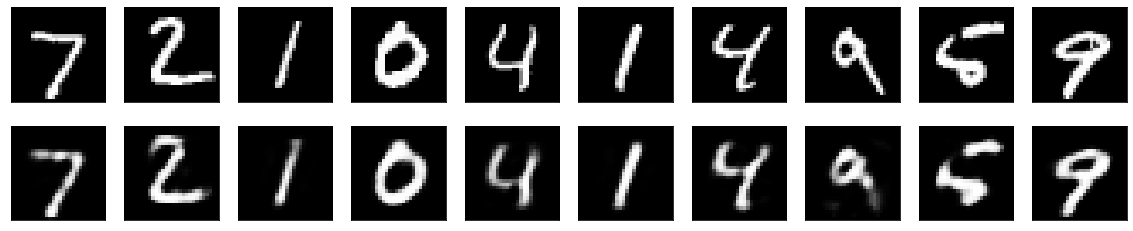

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
